In [1]:
import tensorflow as tf
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [26]:
import PIL
#cheche pillow version
print(PIL.__version__)

9.2.0


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('PlantVillage',shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)


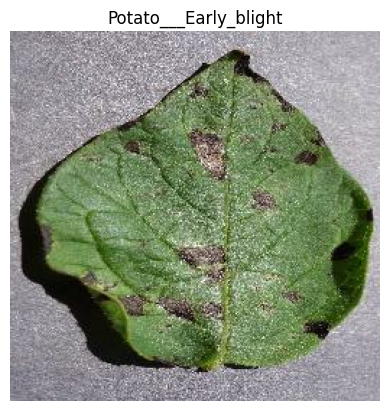

In [5]:
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels_batch[0]])
    plt.axis("off")
    print(image_batch.shape)
   

In [6]:
len(dataset)
#68 x 32 batches = 2176

68

In [7]:
def get_dataset_partitions_tf(ds,train_split=.8,val_split=0.1,test_split = 0.1,shuffle=True,shuffle_buffer_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_buffer_size,seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds
    

In [8]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(val_ds)

6

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [13]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),  
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])


In [14]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
model.fit(train_ds, epochs=EPOCHS,batch_size=BATCH_SIZE, validation_data=val_ds,verbose=2)

Epoch 1/50
54/54 - 28s - loss: 0.9145 - accuracy: 0.4971 - val_loss: 0.9087 - val_accuracy: 0.5833 - 28s/epoch - 513ms/step
Epoch 2/50
54/54 - 10s - loss: 0.7064 - accuracy: 0.7089 - val_loss: 0.7707 - val_accuracy: 0.6771 - 10s/epoch - 178ms/step
Epoch 3/50
54/54 - 9s - loss: 0.5140 - accuracy: 0.7795 - val_loss: 0.5912 - val_accuracy: 0.6979 - 9s/epoch - 173ms/step
Epoch 4/50
54/54 - 9s - loss: 0.3991 - accuracy: 0.8368 - val_loss: 0.3683 - val_accuracy: 0.8438 - 9s/epoch - 173ms/step
Epoch 5/50
54/54 - 9s - loss: 0.2672 - accuracy: 0.8993 - val_loss: 0.4649 - val_accuracy: 0.8438 - 9s/epoch - 174ms/step
Epoch 6/50
54/54 - 9s - loss: 0.1936 - accuracy: 0.9271 - val_loss: 0.3596 - val_accuracy: 0.8802 - 9s/epoch - 176ms/step
Epoch 7/50
54/54 - 9s - loss: 0.1635 - accuracy: 0.9352 - val_loss: 0.5080 - val_accuracy: 0.8281 - 9s/epoch - 175ms/step
Epoch 8/50
54/54 - 9s - loss: 0.1564 - accuracy: 0.9439 - val_loss: 0.3883 - val_accuracy: 0.8438 - 9s/epoch - 175ms/step
Epoch 9/50
54/54 - 9

In [24]:
model.evaluate(test_ds)

8/8 [==============================] - 0s 36ms/step - loss: 0.0965 - accuracy: 0.9883


[0.09647733718156815, 0.98828125]

1/1 [==============================] - 3s 3s/step
[1.1261740e-07 9.9999988e-01 5.3086736e-11]
Potato___Late_blight


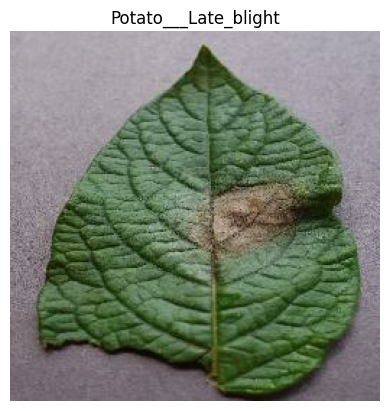

In [20]:
#make predictions
for image_batch, labels_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(dataset.class_names[labels_batch[0]])
    plt.axis("off")
    
    predictions = model.predict(image_batch)
    print(predictions[0])
    print(dataset.class_names[tf.argmax(predictions[0])])
    

In [21]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    predicted_class = dataset.class_names[tf.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]),2)
    return predicted_class,confidence

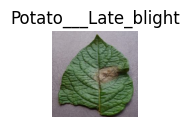

1/1 [==============================] - 1s 557ms/step
Predicted class:  Potato___Late_blight
Confidence:  100.0
Actual class:  Potato___Late_blight



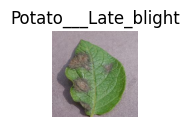

1/1 [==============================] - 0s 30ms/step
Predicted class:  Potato___Late_blight
Confidence:  100.0
Actual class:  Potato___Late_blight



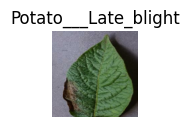

1/1 [==============================] - 0s 29ms/step
Predicted class:  Potato___Late_blight
Confidence:  100.0
Actual class:  Potato___Late_blight



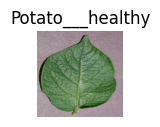

1/1 [==============================] - 0s 34ms/step
Predicted class:  Potato___healthy
Confidence:  100.0
Actual class:  Potato___healthy



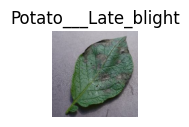

1/1 [==============================] - 0s 33ms/step
Predicted class:  Potato___Late_blight
Confidence:  100.0
Actual class:  Potato___Late_blight



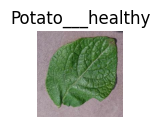

1/1 [==============================] - 0s 27ms/step
Predicted class:  Potato___healthy
Confidence:  100.0
Actual class:  Potato___healthy



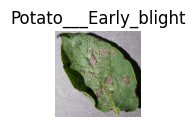

1/1 [==============================] - 0s 30ms/step
Predicted class:  Potato___Early_blight
Confidence:  100.0
Actual class:  Potato___Early_blight



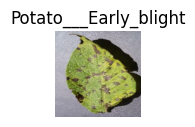

1/1 [==============================] - 0s 27ms/step
Predicted class:  Potato___Early_blight
Confidence:  100.0
Actual class:  Potato___Early_blight



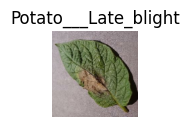

1/1 [==============================] - 0s 25ms/step
Predicted class:  Potato___Late_blight
Confidence:  100.0
Actual class:  Potato___Late_blight



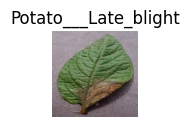

1/1 [==============================] - 0s 28ms/step
Predicted class:  Potato___Late_blight
Confidence:  100.0
Actual class:  Potato___Late_blight



In [22]:
for images,labels in test_ds.take(1):
    for i in range(0,10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels[i]])
        plt.axis("off")
        plt.show()
        predicted_class,confidence = predict(model,images[i])
        print("Predicted class: ",predicted_class)
        print("Confidence: ",confidence)
        print("Actual class: ",dataset.class_names[labels[i]])
        print("")

In [23]:
model.save(f"./models/1")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [25]:
#save model for deployment in gcp h5 format
model.save("model.h5")